In [1]:
import twixtools
from pygrappa import grappa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from pylab import *
from matplotlib.widgets import LassoSelector
from mpl_interactions import image_segmenter

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def phase_comb(sig, axis=1):
    return np.angle(np.sum(sig, axis))

In [2]:
# parse the twix files
data_directory = "TakeOne"
twix_pre = twixtools.read_twix(os.path.join(data_directory, 'meas_MID00345_FID95822_gre_baseline_temp.dat'))
twix_post = twixtools.read_twix(os.path.join(data_directory, 'meas_MID00349_FID95826_gre_postexposure_temp.dat'))

data_directory_noimplant = "TakeTwo"
twix_pre_noimp = twixtools.read_twix(os.path.join(data_directory_noimplant, 'meas_MID00017_FID95848_gre_baseline_temp.dat'))
twix_post_noimp = twixtools.read_twix(os.path.join(data_directory_noimplant, 'meas_MID00022_FID95853_gre_postexposure_temp.dat'))

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix_pre))

Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 5.61M/5.61M [00:00<00:00, 237MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 5.61M/5.61M [00:00<00:00, 179MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 129MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 22.3M/22.3M [00:00<00:00, 308MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 132MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 22.3M/22.3M [00:00<00:00, 261MB/s]


number of separate scans (multi-raid): 1


In [3]:
# access the protocol example: print the TR of the sequence
print('\nTE = %d ms\n'%(twix_pre[-1]['hdr']['Phoenix']['alTE'][3]/1000))


TE = 30 ms



In [4]:
# list the mdh flags and line counters for every 8th measurement data block (mdb)
for mdb in twix_pre[-1]['mdb'][::8]:
    print('line: %3d; flags:'%(mdb.cLin), mdb.get_active_flags())

line:   0; flags: ['ONLINE', 'NOISEADJSCAN']
line:   2; flags: ['ONLINE', 'REFLECT']
line:   6; flags: ['ONLINE', 'REFLECT']
line:  10; flags: ['ONLINE', 'REFLECT']
line:  14; flags: ['ONLINE', 'REFLECT']
line:  18; flags: ['ONLINE', 'REFLECT']
line:  21; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  23; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  25; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  27; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  29; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  31; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  33; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  35; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  37; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  39; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  41; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  43; flags: ['ONLINE', 'PATREFSCAN', 'REFLECT']
line:  46; flags: ['ONLINE', 'REFLECT']
line:  50; flags: ['ONLINE', 'REFLECT']
line:  54; flags: ['ONLINE'

In [147]:
# Now do it all again for pre/post and abbreviate code 
def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    data_cal = cal_data[:].squeeze()
    print(data.shape, data_cal.shape)
    print(len(data.shape))

    #Check for multiple slices
    # Total hack and lots of wasted time but theoretically correct
    if len(data.shape) == 4:
        data = np.tile(data, (4,1,1,1,1))
        data_cal = np.tile(data_cal, (4,1,1,1,1))

        data = np.swapaxes(data, 0,1)
        data_cal = np.swapaxes(data_cal, 0,1)
        #print(data.shape)

    res = np.empty_like(data)
    for slice in np.arange(data.shape[slice_axis]):
        for contrast in np.arange(data.shape[contrast_axis]):
            data_contrast = data[slice, contrast,:,:,:]
            data_cal_contrast = data_cal[slice, contrast,22:46,:,:]
            print(data_cal_contrast.shape, data_contrast.shape)
            res[slice, contrast,:,:,:] = grappa(data_contrast, data_cal_contrast, coil_axis=1, silent=False, kernel_size=(5,5))
    print(res.shape)
    return res

slice_axis = 0
contrast_axis = 1
coil_axis = 3

# Summation approach to combine coils
res_pre = get_grappa_kspace(twix_pre)
res_post = get_grappa_kspace(twix_post)

res_pre_noimp = get_grappa_kspace(twix_pre_noimp)
res_pre_noimp = get_grappa_kspace(twix_post_noimp)

(4, 63, 8, 512) (4, 44, 8, 512)
4
(22, 8, 512) (63, 8, 512)
P took 0.31884 seconds!
A took 0.00658512 seconds
Training and application of weights took 0.520573seconds
(22, 8, 512) (63, 8, 512)
P took 0.298438 seconds!
A took 0.00599766 seconds
Training and application of weights took 0.545784seconds
(22, 8, 512) (63, 8, 512)
P took 0.303631 seconds!
A took 0.00674868 seconds
Training and application of weights took 0.475082seconds
(22, 8, 512) (63, 8, 512)
P took 0.335012 seconds!
A took 0.00568199 seconds
Training and application of weights took 0.500421seconds
(22, 8, 512) (63, 8, 512)
P took 0.274496 seconds!
A took 0.00424719 seconds
Training and application of weights took 0.471037seconds
(22, 8, 512) (63, 8, 512)
P took 0.314823 seconds!
A took 0.00578642 seconds
Training and application of weights took 0.460696seconds
(22, 8, 512) (63, 8, 512)
P took 0.308671 seconds!
A took 0.00657153 seconds
Training and application of weights took 0.621513seconds
(22, 8, 512) (63, 8, 512)
P t

In [148]:
print(res_pre.shape)

image_pre = ifftnd(res_pre, [2,-1])
image_rms_pre = rms_comb(image_pre, coil_axis)
image_presum = np.sum(image_pre, coil_axis)
phase_img_pre = np.angle(image_presum)

image_post = ifftnd(res_post, [2,-1])
image_rms_post = rms_comb(image_post, coil_axis)
image_postsum = np.sum(image_post, coil_axis)
phase_img_post = np.angle(image_postsum)

(4, 4, 63, 8, 512)


(4, 4, 63, 8, 512)


(-0.5, 511.5, -0.5, 62.5)

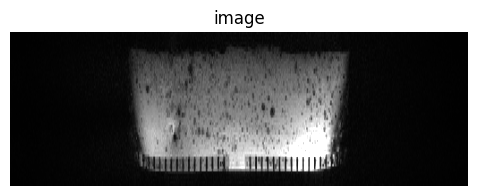

In [149]:
## Check kspace 
slice_index = 3
contrast_index = 2

print(res_pre.shape)
plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(image_rms_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

# plt.subplot(122)
# plt.title('phase pre')
# plt.imshow(phase_img_pre, cmap='gray', origin='lower', aspect='auto')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

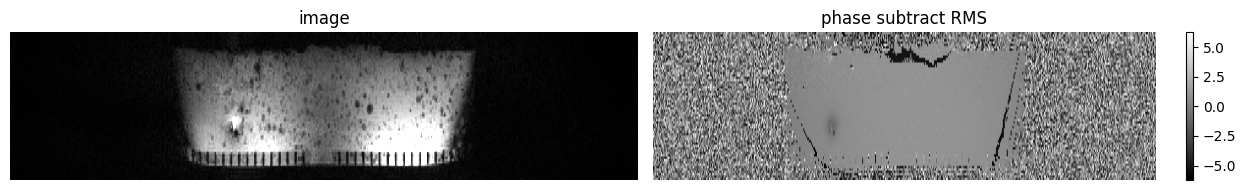

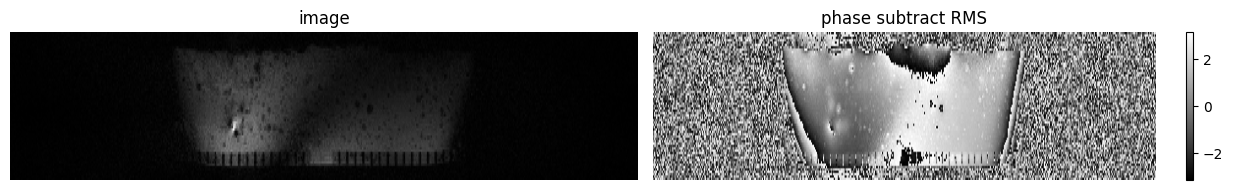

In [190]:
slice_index = 2
contrast_index = 2

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_presum[contrast_index, slice_index]), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase subtract RMS')
plt.imshow(phase_img_post[contrast_index, slice_index] - phase_img_pre[contrast_index, slice_index], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre[contrast_index, slice_index,:,3,:]), cmap='gray', origin='lower', aspect='auto')
plt.axis('off')

plt.subplot(122)
plt.title('phase subtract RMS')
plt.imshow(np.angle(image_pre[contrast_index, slice_index,:,3,:]), cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

0.01


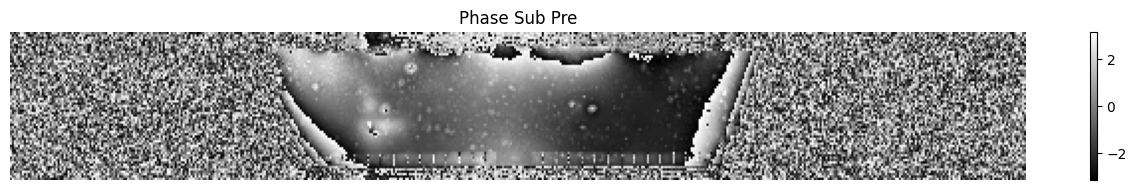

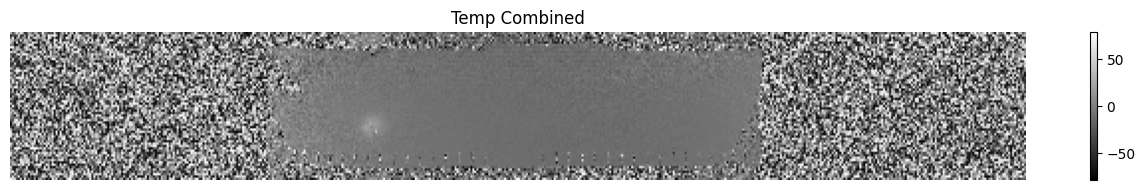

In [201]:
## Calculate temperature map
slice_index = 2
contrast_index = 1
c1, c2 = 3,0

alpha = -0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
# TE = twix_pre[-1]['hdr']['Phoenix']['alTE'][c1]/1e6 - twix_pre[-1]['hdr']['Phoenix']['alTE'][c2]/1e6
TE = twix_pre[-1]['hdr']['Phoenix']['alTE'][contrast_index]/1e6
print(TE)

# ## Simple temp map first
# TE = twix_pre[-1]['hdr']['Phoenix']['alTE'][contrast_index]/1e6
# phase_sub = phase_img_post[contrast_index, slice_index] - phase_img_pre[contrast_index, slice_index]
# temp_map = (phase_sub) / (alpha*gyromagnetic_ratio*B0*TE)

# Do first phase subtraction within acquisition
# phase_sub_within_pre = np.multiply(image_presum[c1,slice_index],np.conj(image_presum[c2,slice_index]))
# phase_sub_within_post = np.multiply(image_postsum[c1,slice_index],np.conj(image_postsum[c2,slice_index]))
phase_sub_complex = np.angle(np.multiply(image_post[contrast_index,slice_index,:,4,:],np.conjugate(image_pre[contrast_index,slice_index,:,4,:])))
temp_map = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)

plt.figure(figsize=[13,2])
plt.title('Phase Sub Pre')
plt.imshow(np.angle(image_presum[3,slice_index]), cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
plt.imshow(temp_map, cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

(63, 512)


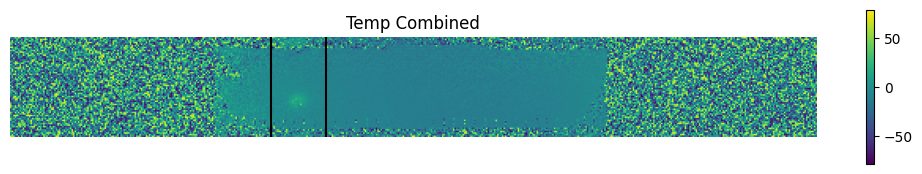

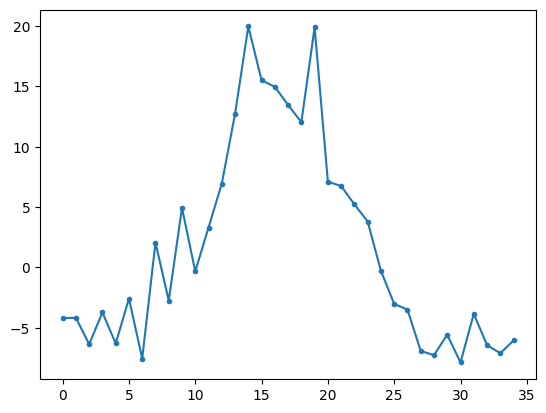

In [202]:
xstart, xstop = 165, 200
ystart, ystop = 21, 21

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
print(temp_map.shape)
#plt.plot([0,512],[ystart,ystop], 'k-')
plt.plot([xstart,xstart],[0,63], 'k-')
plt.plot([xstop,xstop],[0,63], 'k-')
plt.imshow(temp_map, origin='lower')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

fig = plt.figure()
plt.plot(moving_average(temp_map[ystart,xstart:xstop],1), '.-')
plt.show()

In [124]:
# Now do it all again for pre/post and abbreviate code 
def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    print(data.shape)
    data = data[0,3,:,:,:]    
    data_cal = cal_data[:].squeeze()
    print(data_cal.shape)
    data_cal = data_cal[0,3,22:46,:,:]

    res = grappa(data, data_cal, coil_axis=1, silent=False)
    return res

def get_image_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    im_data.flags['remove_os'] = False
    data = im_data[:].squeeze()
    print(data.shape)

    return data

res_pre = np.sum(get_grappa_kspace(twix_pre_noimp),1)
res_post = np.sum(get_grappa_kspace(twix_post_noimp),1)

image_pre = ifftnd(res_pre, [0,-1])
image_rms_pre = rms_comb(image_pre)
phase_img_pre = np.angle(image_pre)
phase_img_comb_pre = phase_comb(image_pre)

image_post = ifftnd(res_post, [0,-1])
image_rms_post = rms_comb(image_post)
phase_img_post = np.angle(image_post)
phase_img_comb_post = phase_comb(image_post)


(4, 4, 63, 8, 512)
(4, 4, 44, 8, 512)
P took 0.327422 seconds!
A took 0.010473 seconds
Training and application of weights took 0.486025seconds
(4, 4, 63, 8, 512)
(4, 4, 44, 8, 512)
P took 0.385001 seconds!
A took 0.00846815 seconds
Training and application of weights took 0.452012seconds


(63, 512)


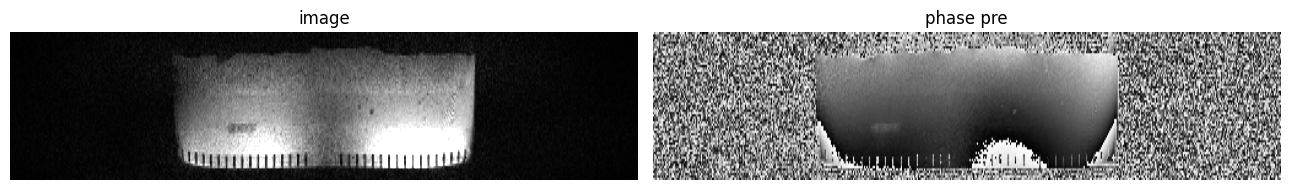

In [126]:
## Check kspace 
print(res_pre.shape)
plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase pre')
plt.imshow(phase_img_pre, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

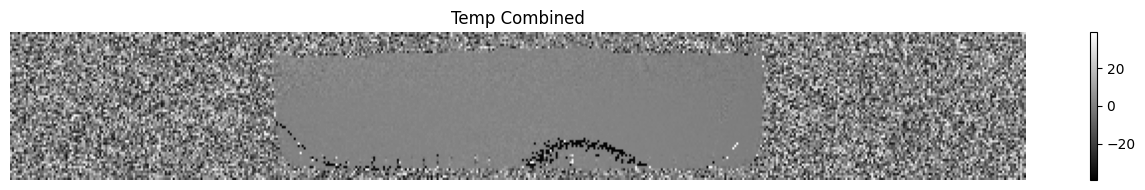

(63, 512)


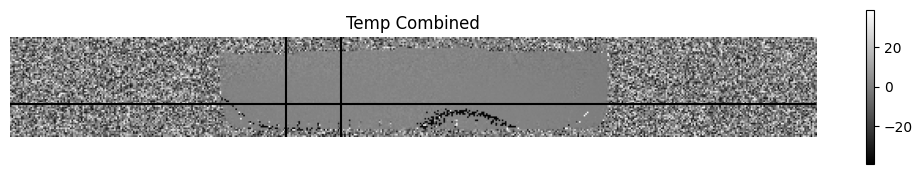

(45,)


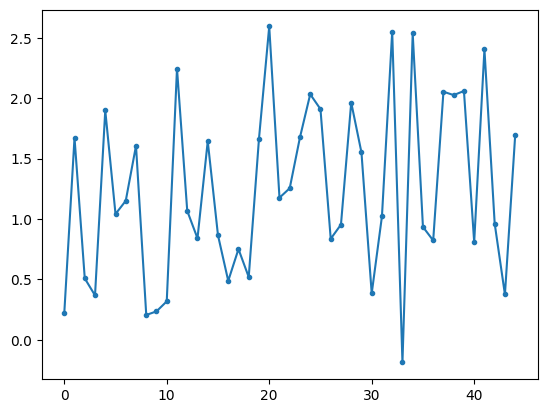

In [129]:
# Calculate temperature map
alpha = 0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
TE = 0.040 #s
phase_sub_complex = np.angle(np.multiply(image_post,image_pre))
phase_sub_comb = phase_img_post - phase_img_pre
temp_map_comb = (phase_img_post - phase_img_pre) / (alpha*gyromagnetic_ratio*B0*TE)
# temp_map_comb = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
plt.imshow(temp_map_comb, cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
print(temp_map_comb.shape)
plt.plot([0,512],[20,20], 'k-')
plt.plot([175,175],[0,63], 'k-')
plt.plot([210,210],[0,63], 'k-')
plt.imshow(temp_map_comb, cmap='gray', origin='lower')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

fig = plt.figure()
print(temp_map_comb[20,155:200].flatten().shape)
plt.plot(temp_map_comb[20,155:200], '.-')
plt.show()

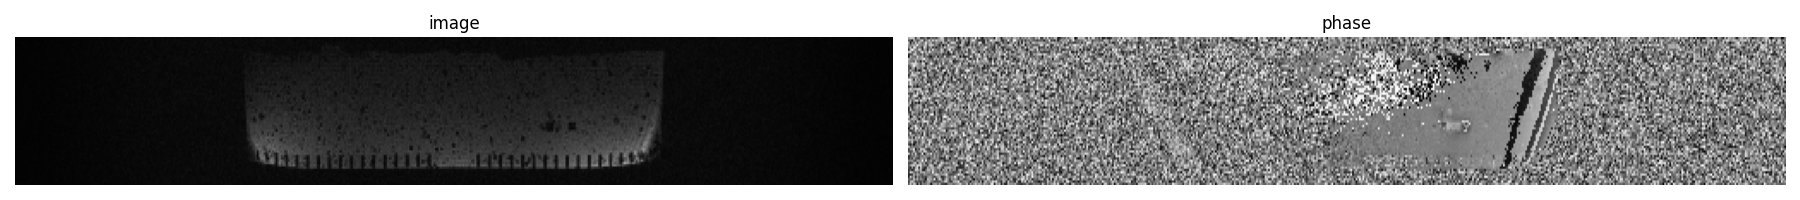

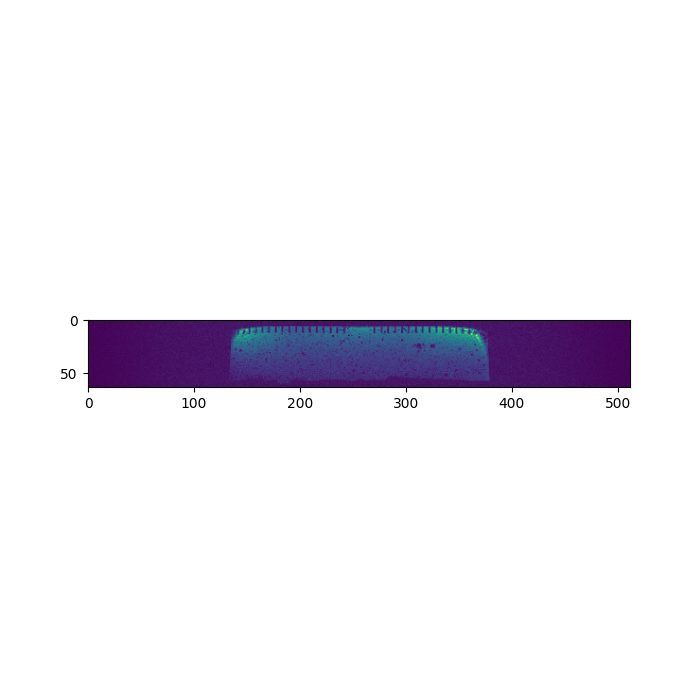

In [29]:
# Now get ROI specific information


def onselect(verts):
    print(verts)

%matplotlib ipympl

fig = plt.figure(figsize=[12,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

ax = plt.subplot(122)
plt.title('phase')
ax.imshow(phase_img_pre[:,0,:] - phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

segmenter = image_segmenter(abs(image_rms_post), mask_colors='red', mask_alpha=0.76, figsize=(7, 7))
display(segmenter)


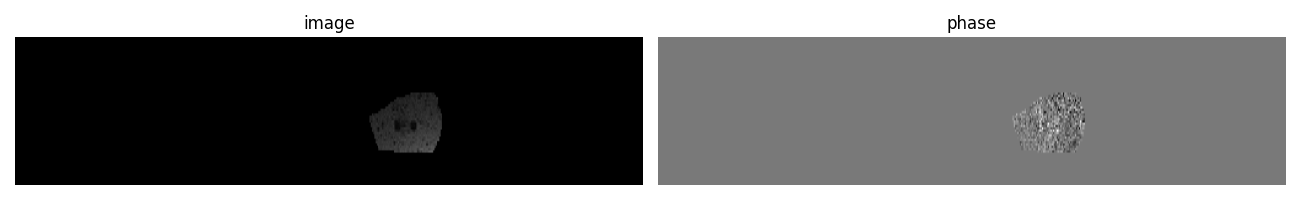

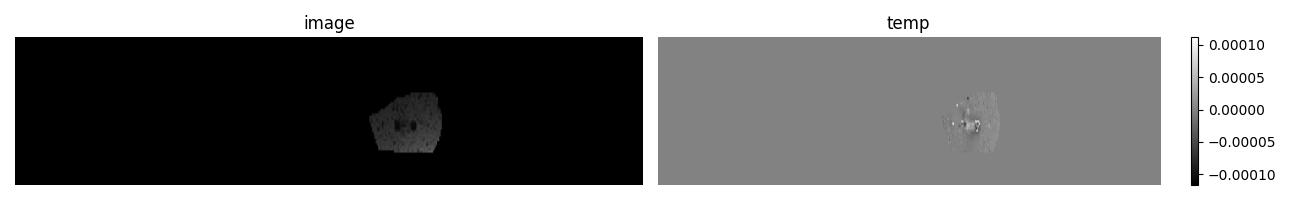

In [38]:
%matplotlib widget

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow((phase_img_rms_pre - phase_img_rms_post) * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('temp')
plt.imshow(temp_map * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.colorbar()
plt.show()

NameError: name 'res' is not defined

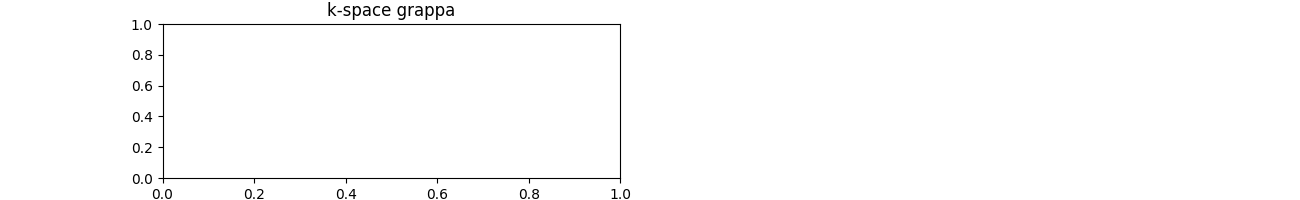

In [31]:
for channel in range(4):

    plt.figure(figsize=[13,2])
    plt.subplot(121)
    plt.title('k-space grappa')
    plt.imshow(abs(res[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    plt.subplot(122)
    plt.title('k-space original')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.figure(figsize=[13,2])
image = ifftnd(res, [0,-1])
image_rms = rms_comb(image)
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

phase_img = np.angle(image)
phase_img_rms = rms_comb(phase_img)
plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
    
plt.tight_layout()

print(np.max(phase_img))

In [11]:
# Now make phase map for pre/post



In [12]:
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 372MB/s]


In [13]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
print(data.shape)

(10, 63, 4, 512)
